In [116]:
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.data
import random
import matplotlib.pyplot as matpy
import math

torch.manual_seed(1)


In [118]:
dict_Vectors = {}

with open("preTrainedVectors_mini.txt") as inputFile:
    Vectors = inputFile.readlines()
    
    for vec in Vectors:
        data = vec.split()
        if data[0] not in dict_Vectors.keys():
            dict_Vectors[data[0]] = data[1:]
            
#print(dict_Vectors.keys())

In [119]:
#print(dict_Vectors.keys())

#Make input vectors

def make_batch_input_vector(batch_target,batch_relata):
    
    batch_relation_vector = []
    
    for target,relata in zip(batch_target,batch_relata):
    
        word1 = target.lower()
        word2 = relata.lower()
    
        #collect the respective vectors for word 1 & 2
        
        vector_1 = np.array(dict_Vectors[word1])
        vector_1 = np.ndarray.astype(vector_1,float)
        vector_2 = np.array(dict_Vectors[word2])
        vector_2 = np.ndarray.astype(vector_2,float)
    
        #Combine these two vectors to form a single vector
    
        relation_vector = vector_1 - vector_2    
        
        batch_relation_vector.append(relation_vector)
    
    return(torch.FloatTensor(batch_relation_vector))

def make_batch_target_vector(batch_relation):
    
    batch_relation_indices = []
    
    for relation in batch_relation:
        batch_relation_indices.append(labels_to_ix[relation])
    return(torch.LongTensor(batch_relation_indices))

In [137]:
class RelationClassifier(nn.Module):
    # Module which implements the model
    def __init__ (self,input_dim, hidden_dim, output_dim):
        nn.Module.__init__(self)
        
        self.linear_input = nn.Linear(input_dim,hidden_dim)
        self.linear_hidden = nn.Linear(hidden_dim,output_dim)
        
    def forward(self, batch_input_vector):
        
        batch_size = len(batch_input_vector)      
        batch_output = autograd.Variable(torch.zeros(batch_size,8))
        
        for index,input_vector in enumerate(batch_input_vector):
        
            hidden_layer = self.linear_input(input_vector)
            hidden_units = F.tanh(hidden_layer)
            output = self.linear_hidden(hidden_units)
            
            batch_output[index] = output
            
        return(F.log_softmax(batch_output))
    

In [216]:
#MODEL

INPUT_DIM = 400
HIDDEN_UNIT = 400
OUTPUT_LABEL = 8
BATCH_SIZE = 8

model = RelationClassifier(INPUT_DIM, HIDDEN_UNIT, OUTPUT_LABEL)
loss = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.09)

loss?


Epoch : 0
torch.Size([32, 8]) torch.Size([32])
torch.Size([32, 8]) torch.Size([32])
torch.Size([32, 8]) torch.Size([32])
torch.Size([32, 8]) torch.Size([32])
torch.Size([32, 8]) torch.Size([32])
torch.Size([32, 8]) torch.Size([32])
torch.Size([6, 8]) torch.Size([6])


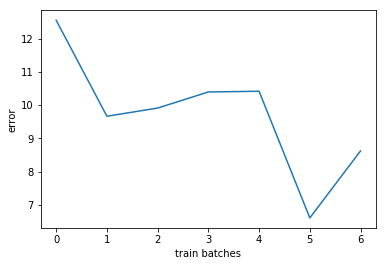

In [260]:
for epoch in range(1):
    
    bs = 32
    
    #SPlit dataset to avoid lexical memorization
    print("Epoch :", epoch)
    with open("UniqueTuples_mini") as inputFile:
        content = inputFile.readlines()
        total_data = len(content) 
        #60% train, 10% dev, 30% test
        random.shuffle(content)
        train_data  = content[0:int(total_data*.6)]
        dev_data    = content[int(total_data*.6):int(total_data*.7)]
        test_data   = content[int(total_data*.7):]


    N = math.ceil(len(train_data)/bs)

    labels_to_ix = {}
    Train_Error_cost = []

    for i in range(N):

        batch_entry = train_data[i*bs:i*bs+bs]

        batch_concept = []
        batch_relata = []
        batch_relation = []

        for index,split_data in enumerate(batch_entry):
            batch_concept.append(split_data.split()[0])
            batch_relata.append(split_data.split()[1])
            batch_relation.append(split_data.split()[2])

            if split_data.split()[2] not in labels_to_ix:
                labels_to_ix[split_data.split()[2]] = len(labels_to_ix)


        batch_input_vector = autograd.Variable(make_batch_input_vector(batch_concept,batch_relata))
        batch_target_label = autograd.Variable(make_batch_target_vector(batch_relation))

        model.zero_grad()

        #print(batch_input_vector.data.shape, batch_target_label.data.shape)

        batch_log_prob = model(batch_input_vector)
        print(batch_log_prob.data.shape, batch_target_label.data.shape)
        batch_cost = loss(batch_log_prob,batch_target_label)
        
        batch_cost.backward()
        optimizer.step()


        Train_Error_cost.append(batch_cost.data.tolist())

    #print(Error_cost)
    matpy.plot(Train_Error_cost)
    matpy.ylabel("error")
    matpy.xlabel("train batches")
    matpy.show()


In [284]:
N = math.ceil(len(dev_data)/bs)

labels_to_ix = {}
Dev_Error_cost = []

count = 0

for i in range(N):
    
    batch_entry = dev_data[i*bs:i*bs+bs]
    
    batch_concept = []
    batch_relata = []
    batch_relation = []
    
    for index,split_data in enumerate(batch_entry):
        batch_concept.append(split_data.split()[0])
        batch_relata.append(split_data.split()[1])
        batch_relation.append(split_data.split()[2])
      
        if split_data.split()[2] not in labels_to_ix:
            labels_to_ix[split_data.split()[2]] = len(labels_to_ix)
    
    
    batch_input_vector = autograd.Variable(make_batch_input_vector(batch_concept,batch_relata))
    batch_target_label = autograd.Variable(make_batch_target_vector(batch_relation)) 
    
    batch_log_prob = model(batch_input_vector)
        
    batch_cost = loss(batch_log_prob,batch_target_label)
    batch_cost.backward()
    optimizer.step()
    
    Dev_Error_cost.append(batch_cost.data.tolist())
    
    for predict_label,target_label in zip(batch_log_prob.max(dim=1)[1].data,batch_target_label.data):
        #print(predict_label,target_label)
        if predict_label == target_label:
            count += 1


[[1.391742467880249]]


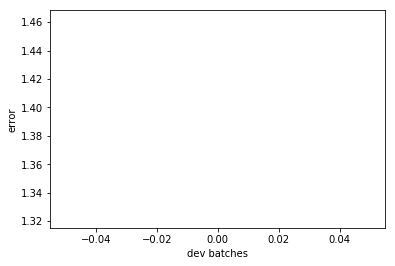

In [285]:
#Validation error

print(Dev_Error_cost)
matpy.plot(Dev_Error_cost)
matpy.ylabel("error")
matpy.xlabel("dev batches")
matpy.show()

#[print(i) for i in range(200) if i%25 == 0]

In [286]:
print("Accuracy",(count/len(dev_data))*100)

Accuracy 62.5
